In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import tensorflow
import tensorflow.config
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tensorflow.config.experimental.set_memory_growth(gpu, True)

# Prepare model

In [3]:
import warnings
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tqdm import tqdm
tqdm.pandas()

tensorflow.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore') 
model = tensorflow.keras.applications.inception_v3.InceptionV3() #Load pretrained model

c:\python38\lib\site-packages\tqdm\std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from pycocotools.coco import COCO
dataDir='dataset'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


# Prepare our candidate image

In [5]:
superclasses = {
    'n02084071': 'dog',
    'n01503061': 'bird',
    'n02120997': 'cat',
    'n02858304': 'boat',
    'n02075296': 'bear',
}

dog_classes = [
    'n02084071', 'n02092468', 'n02095727', 'n02096756', 'n02104523',
    'n02093056', 'n02099029', 'n02090827',  'n02103406', 'n02087122',
    'n02087551', 'n02099997', 'n02104882', 'n02088839', 'n02112826',
    'n02085374', 'n02115335', 'n02095412', 'n02111626', 'n02108672',
    'n02100399', 'n02107420', 'n02090475', 'n02113335', 'n02109811',
    'n02101108', 'n02095050', 'n02101861', 'n02086478', 'n02103841',
    'n02106966'
]

bear_classes = [
    'n02131653'
]

cat_classes = [
    'n02121808'
]

boat_classes = [
    'n03790230', 'n04128499', 'n04244997', 'n04128837', 'n02858304',
]

#car_classes = [
#    'n04170037', 'n02959942', 'n04490091', 'n02924116', 'n02924116',
#    'n02958343', 'n04520170'
#]



f = open('./wordnet.is_a.txt', 'r')

# mapping that takes class ID => superclass ID
is_a_dict = dict()
is_a_dict_label = dict()
for line in f.readlines():
    if len(line) < 1:
        continue
    superclass_id, class_id = line.split(' ')
    
    is_a_dict[class_id.replace('\n', '')] = superclass_id
    
    label = None
    if superclass_id in dog_classes:
        label = 'dog'
    elif superclass_id in boat_classes:
        label = 'boat'
    elif superclass_id in bear_classes:
        label = 'bear'
    elif superclass_id in cat_classes:
        label = 'cat'
    
    is_a_dict_label[class_id.replace('\n', '')] = label


177


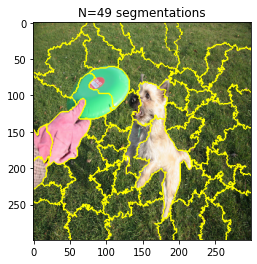

Subgroup=n02092468,  label=dog	(conf=0.94,	name=cairn)
Subgroup=n02092468,  label=dog	(conf=0.02,	name=Border_terrier)
Subgroup=n03666917,  label=None	(conf=0.00,	name=balloon)
Subgroup=n02090475,  label=dog	(conf=0.00,	name=Irish_wolfhound)
Subgroup=n02104523,  label=dog	(conf=0.00,	name=briard)
Subgroup=n02092468,  label=dog	(conf=0.00,	name=Irish_terrier)
Subgroup=n02104882,  label=dog	(conf=0.00,	name=malinois)
Subgroup=n02092468,  label=dog	(conf=0.00,	name=Australian_terrier)
Subgroup=n02092468,  label=dog	(conf=0.00,	name=Yorkshire_terrier)
Subgroup=n02096756,  label=dog	(conf=0.00,	name=miniature_schnauzer)


In [9]:
from skimage.io import imread
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, chan_vese
from skimage.segmentation import mark_boundaries
from skimage.color import rgb2gray
from skimage.transform import resize, rotate
from pycocotools.coco import COCO

catIds = coco.getCatIds(catNms=['dog']);
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]


img = imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
#img = imread("images/dog3.jpg")
img = resize(img, (299,299)) 
img = rotate(img, angle=0)
X = (img - 0.5)*2 #Inception pre-processing

superpixels = quickshift(img, kernel_size=5, max_dist=300, ratio=0.2)
# superpixels = quickshift(img)
# superpixels = felzenszwalb(img, scale=100, sigma=0.5, min_size=200)
#gray = rgb2gray(img)
#superpixels = chan_vese(gray)

N = np.unique(superpixels).shape[0]


print(len(imgIds))

plt.imshow(mark_boundaries(img, superpixels))
plt.title('N=%d segmentations' % N)
plt.show()

preds = model.predict(X[np.newaxis,:,:,:])
top_pred_classes = preds[0].argsort()[-10:][::-1]
for pred in decode_predictions(preds, top=10)[0]:
    subgrp, label = is_a_dict.get(pred[0], None), is_a_dict_label.get(pred[0], None)
    print('Subgroup=%s,  label=%s\t(conf=%.2f,\tname=%s)' % (subgrp, label, pred[2], pred[1]))

# Prepare perturbations

In [10]:
import copy
import random

num_perturb = 400
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, N))


#nums_to_turn_on = np.random.randint(N, size=(num_perturb))
#perturbations = list()
#for n in nums_to_turn_on:

#    P = np.array([0] * (N-n) + [1] * n)
#    np.random.shuffle(P)
#    perturbations.append(P)

def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image * mask[:,:,np.newaxis]
    return perturbed_image

all_perturbations = np.zeros((num_perturb, 299, 299, 3))
for i, pert in enumerate(perturbations):
    perturbed_img = perturb_image(X, pert, superpixels)
    all_perturbations[i,:,:,:] = perturbed_img

predictions = model.predict(all_perturbations)

# Weight perturbations by similarity to original image

In [11]:
import sklearn.metrics
original_image = np.ones(N)[np.newaxis,:]
distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function

# Fit linear model

Explanation for class: cairn (p=0.945)


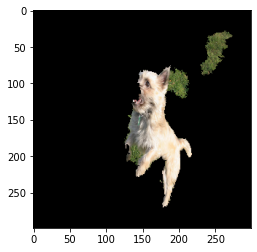

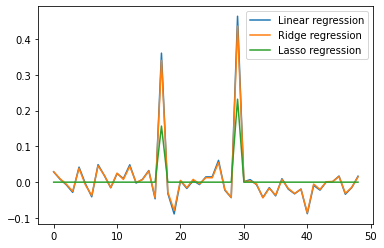

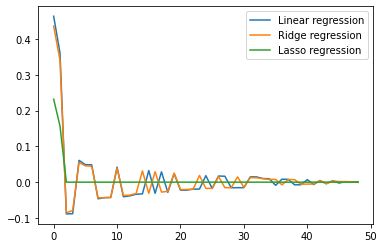

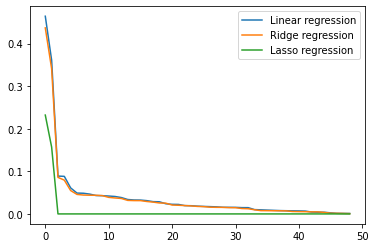

In [87]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV

c = 0
class_to_explain = top_pred_classes[c]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:, class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_

A = LinearRegression().fit(X=perturbations, y=predictions[:, class_to_explain], sample_weight=weights).coef_
#B_clf = RidgeCV(alphas=(0.1, 1, 5, 10, 50, 75, 100, 150, 200)).fit(X=perturbations, y=predictions[:, class_to_explain])
#C_clf = LassoCV().fit(X=perturbations, y=predictions[:, class_to_explain])
#B = B_clf.coef_
#C = C_clf.coef_

B = Ridge(alpha=5).fit(X=perturbations, y=predictions[:, class_to_explain], sample_weight=weights).coef_
C = Lasso(alpha=0.05).fit(X=perturbations, y=predictions[:, class_to_explain], sample_weight=weights).coef_


num_top_features = 5
top_features = np.argsort(coeff)[-num_top_features:]
top_features

mask = np.zeros(N)
mask[top_features]= True
plt.imshow(perturb_image(X/2+0.5, mask, superpixels))
print('Explanation for class: %s (p=%.3f)' % decode_predictions(preds)[0][c][1:])
plt.show()

plt.plot(A, label='Linear regression')
plt.plot(B, label='Ridge regression')
plt.plot(C, label='Lasso regression')
plt.legend(loc='best')
plt.show()

plt.plot(sorted(A, key=abs, reverse=True), label='Linear regression')
plt.plot(sorted(B, key=abs, reverse=True), label='Ridge regression')
plt.plot(sorted(C, key=abs, reverse=True), label='Lasso regression')
plt.legend(loc='best')
plt.show()

plt.plot(sorted(abs(A), reverse=True), label='Linear regression')
plt.plot(sorted(abs(B), reverse=True), label='Ridge regression')
plt.plot(sorted(abs(C), reverse=True), label='Lasso regression')
plt.legend(loc='best')
plt.show()

In [88]:
B_clf.alpha_


5.0

# Build a validation dataset

In [84]:
flatten = lambda t: [item for sublist in t for item in sublist]

imgIds = [coco.getImgIds(catIds=coco.getCatIds(catNms=[term])) for term in ['dog','bear','cat','boat']]
imgIds = flatten(imgIds)

imgs = coco.loadImgs(imgIds)

blacklist = list()

img_vector = np.zeros((len(imgs), 299, 299, 3))
for idx, I in enumerate(imgs):
    img = imread('%s/images/%s/%s'%(dataDir,dataType,I['file_name']))
    img = resize(img, (299,299)) 

    if img.shape != (299, 299, 3):
        print('fuck', idx)
        blacklist.append(idx)
        continue

    X = (img - 0.5)*2 #Inception pre-processing

    img_vector[idx, :, :, :] = X

# get initial predictions
val_predictions = model.predict(img_vector)

fuck 525


In [88]:
val_list = list()
for idx, raw_preds in enumerate(val_predictions):    
    if idx in blacklist:
        continue
        
    decoded_preds = decode_predictions(np.array(raw_preds).reshape(1, 1000), top=5)[0]
    top_indices = np.argsort(raw_preds)[::-1]
    
    preds = [(i, is_a_dict_label.get(p[0], None)) for i,p in zip(top_indices, decoded_preds)]
    preds = list(filter(lambda x: x[1] is not None, preds))
    
    if len(preds) < 1:
        continue

    class_to_explain, label = preds[0]

    imgId = imgIds[idx]
    if imgId == None:
        continue
        
    val_list.append((idx, label, class_to_explain))

val_df = pd.DataFrame(val_list, columns=["idx", "label", "imagenet_class_to_explain"])
val_df.label.value_counts()

dog     176
cat      80
boat     67
bear     46
Name: label, dtype: int64

# Use validation set

In [182]:
val_df

,idx,label,imagenet_class_to_explain
0,0,dog,208
1,1,dog,209
2,2,dog,232
3,3,dog,203
4,4,dog,197
...,...,...,...
364,523,boat,484
365,524,boat,576
366,528,boat,554
367,529,boat,814


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

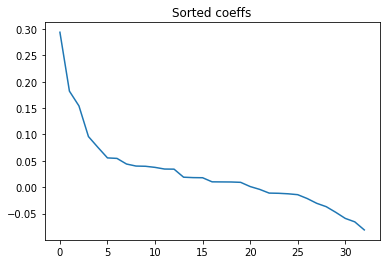

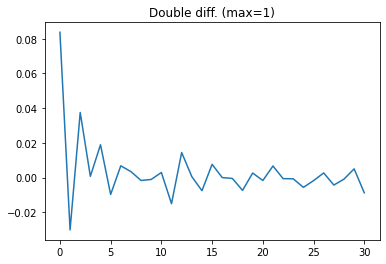

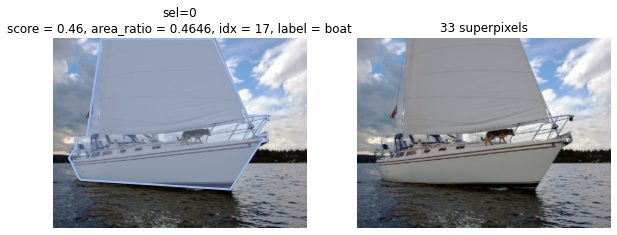

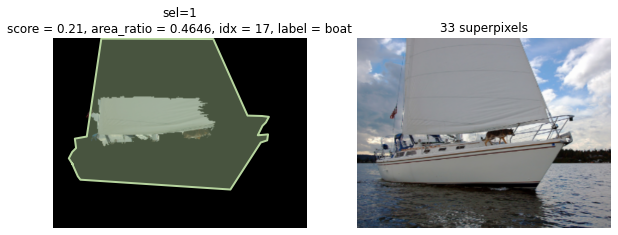

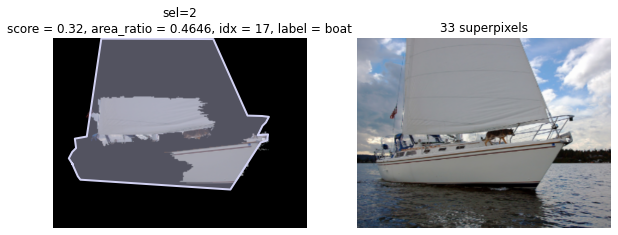

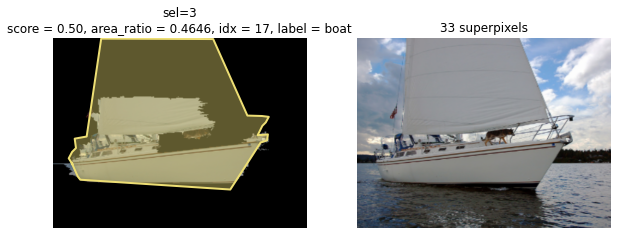

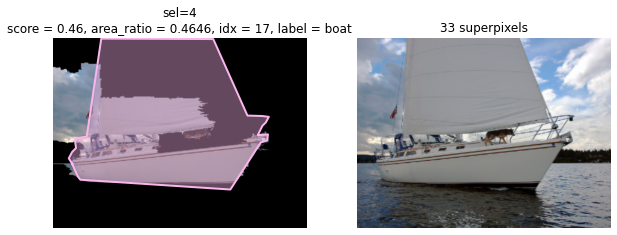

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.24s/it]


15    None
dtype: object

In [181]:
import copy
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from PIL import Image
import random

def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image * mask[:,:,np.newaxis]
    return perturbed_image

def calculate_score(img_mask, coco_mask):
    intersection = np.sum(img_mask * coco_mask)
    union = np.sum(img_mask + coco_mask)

    return intersection / union

skipped_count = 0
high_score = 0.0

# random.shuffle(val_list)

def process_row(row):
    global N, num_perturb, coeffs, lag, perturbations, predictions
    idx, label, class_to_explain = row
    
    I = imgs[idx]
    img = imread('%s/images/%s/%s'%(dataDir,dataType,I['file_name']))
    og_size = img.shape
    img = resize(img, (299,299)) 
    X = (img - 0.5)*2 #Inception pre-processing
    
    # perform LIME
    superpixels = quickshift(img, kernel_size=5, max_dist=300, ratio=0.2)
    N = np.unique(superpixels).shape[0]
    num_perturb = 250
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, N))
    all_perturbations = np.zeros((num_perturb, 299, 299, 3))
    for i, pert in enumerate(perturbations):
        perturbed_img = perturb_image(X, pert, superpixels)
        all_perturbations[i,:,:,:] = perturbed_img
    predictions = model.predict(all_perturbations)
    
    # weights
    original_image = np.ones(N)[np.newaxis,:]
    distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:, class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_

    coeffs = coeff

    coeffs = -np.sort(-coeffs)

    lag = np.diff(coeffs, n=2)
    best_index = np.where(lag > 0)[0][0] + 1

    # print(coeffs)
    plt.title('Sorted coeffs')
    plt.plot(coeffs)
    plt.show()
    plt.title('Double diff. (max=%d)' % best_index)
    plt.plot(lag)
    plt.show()
    
    
    examples = [best_index - 1, best_index, best_index + 1, best_index + 2, best_index + 3]
    
    for num_top_features in examples:
    
        top_features = np.argsort(coeff)[-num_top_features:]

        mask = np.zeros(N)
        mask[top_features]= True
        og_img = resize(perturb_image(img, mask, superpixels), og_size)

        # load COCO annotation
        annIds = coco.getAnnIds(imgIds=I['id'], catIds=coco.getCatIds(catNms=label))
        anns = coco.loadAnns(annIds)
        # coco.showAnns(anns)

        # compute score
        img_mask = resize(perturb_image(np.ones((img.shape[0],img.shape[1],1)), mask, superpixels), (og_size[0], og_size[1])).squeeze().astype('bool')
        if len(anns) < 1:
            skipped_count += 1
            return { 'score': None, 'label': None, 'area_ratio': None, 'idx': None }
        ann_scores = [calculate_score(img_mask, coco.annToMask(ann).astype('bool')) for ann in anns]
        score = max(ann_scores)
        best_ann = np.argmax(ann_scores)
        area_ratio = np.sum(coco.annToMask(anns[best_ann])) / (og_size[0] * og_size[1])

        if True:
            high_score = score
            plt.figure(figsize=(10,20))
            plt.subplot(1,2,1)
            plt.title('sel=%d\nscore = %.2f, area_ratio = %.4f, idx = %d, label = %s' % (num_top_features, score, area_ratio, idx, label))
            plt.imshow(og_img)
            coco.showAnns([anns[best_ann]])
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.title('%d superpixels' % N)
            plt.imshow(resize(img, og_size))
            plt.axis('off')
            plt.show()

        # return { 'score': score, 'label': label, 'area_ratio': area_ratio, 'idx': idx }

example = 15

results = val_df[example:example+1].progress_apply(lambda r: process_row(r), axis=1, result_type='expand')
results
#print('Done! Skipped %d due to missing annotations' % skipped_count)

In [175]:
np.where(lag > 0)[0][0]

0

In [165]:
perturbations.shape

(250, 44)

In [167]:
coeffs

array([ 0.00002559,  0.00002423,  0.00001404,  0.00001068,  0.00001057,
        0.0000086 ,  0.00000786,  0.00000183,  0.00000134,  0.00000128,
       -0.00000252, -0.00000294, -0.00000502, -0.00000669, -0.00000703,
       -0.00000756, -0.00000852, -0.00000863, -0.00000955, -0.00000996,
       -0.00001438, -0.00001465, -0.00001613, -0.00002119, -0.00002215,
       -0.00002236, -0.00002241, -0.00002362, -0.00002374, -0.0000285 ,
       -0.00004075, -0.00004355, -0.0000463 , -0.00005311])

# Explore metrics

In [365]:
metrics = np.asarray(scores)
metrics.shape

(337, 3)

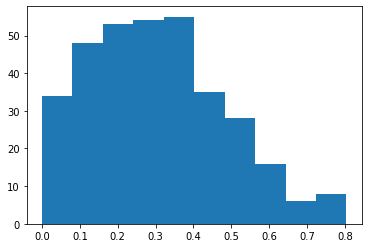

mean IoU = 0.30


In [366]:
plt.hist(metrics[:,0])
plt.show()
print('mean IoU = %.2f' % np.mean(metrics[:,0]))

# TODO list (in no particular order):

* Improve image segmentation?
* Perturbation vs. original distance/similarity calculation
* Improve linear classifier (more regularization?)
* More sensible perturbations? (binomial might not be the best)
    * Possibly introduce image augmentations (e.g. rotation, etc.)
* Construct proper validation dataset
    * Freehand outline regions of interest?
    * Metric for evaluation
* Determine optimal amount of perturbations (based on N_superpixels, etc.)
* Experiment with various ways of masking perturbed images:
    * Different color for negatively masked pixels (instead of black=0)
    * Smooth rough edges to avoid intoducing any unwanted edges

# Updated TODO list (in particular order):

1) Image segmentation dataset as validation set

2) Pick one

In [4]:
import argparse

parser = argparse.ArgumentParser(description='LIME evaluation tool')
parser.add_argument('-n', '--num_perturb')
args = parser.parse_args('-n 50'.split())

print(args)

Namespace(num_perturb='50')


In [ ]:
vars